Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


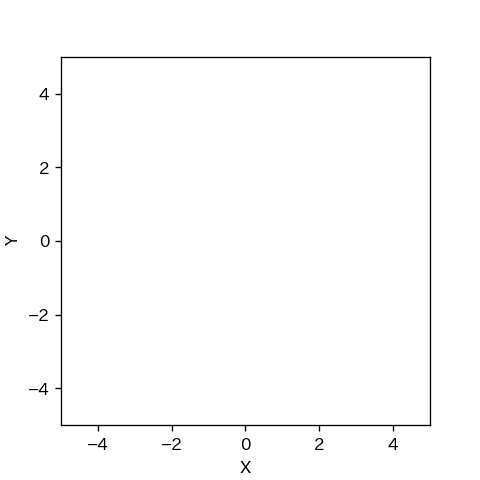

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


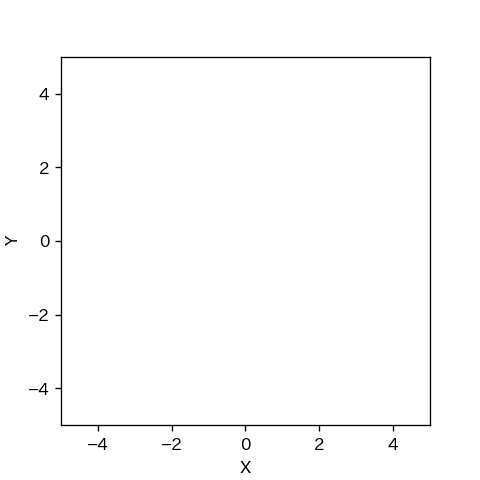

(array([ 4.46010904,  0.41076132, -2.5477517 ]),
 array([-3.59905626,  0.32335325, -2.93789371]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.341308637028755]
0 真値: [-2.31011136 -1.50988433  6.5673854 ] 推定値: [-2.46849137 -1.68353991  6.66486037] 誤差: 0.23503295135758837
1
[7.140986301751884]
1 真値: [-0.93591468 -3.45650459  5.88248097] 推定値: [-1.24915825 -3.58613991  5.94540497] 誤差: 0.3390086268871998
2
[6.237711531509695]
[2.9442098745230982]
[6.024759826439999]
2 真値: [ 2.80449885 -1.59029265  7.38786614] 推定値: [ 3.07647224  8.26571516 -2.01405439] 誤差: 9.859759609579365
[4.239218448721555]
3 真値: [2.87998718 3.02022527 3.26771456] 推定値: [2.86781728 3.04470267 3.00698949] 誤差: 0.027335869264430233
3
4 真値: [-4.0256484  -2.77405335  4.45026495] 推定値: [-3.32560228 -2.69594915  4.63129166] 誤差: 0.7043896884146136
4
[3.9339774965883745]
5 真値: [-3.36849236 -4.2941888   5.75347058] 推定値: [-3.62777195 -4.59667683  5.81277538] 誤差: 0.39840296080905496
5
[5.426011984787132]
[6.2818186354298104]
6 真値: [-4.73623553 -4.595092    6.06885587] 推定値: [-11.07026113   2.44343234   4.38027294] 誤差: 9.468933680662424
[5.602474792427864]
[6.018774120840083

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[6.203318373172519]
[3.6324110944575216]
20 真値: [ 1.60983604 -1.89837291  5.4723726 ] 推定値: [ 3.1517132  -3.2382636   3.24379601] 誤差: 2.042716878796515
[2.3822805308415536]
21 真値: [-2.20039117  0.75332482  9.28669742] 推定値: [-2.2169108   1.09631721  9.44781474] 誤差: 0.3433899854372325
11
[3.8784169678474165]
22 真値: [0.3570578  3.85075088 3.68581277] 推定値: [0.99039865 3.58672415 3.53365587] 誤差: 0.6861710812593076
12
[3.7877922342621164]
23 真値: [-2.74571813 -2.6154893   7.81404462] 推定値: [-2.79374964 -2.48158149  7.90544248] 誤差: 0.14226147759363916
13
[1.0876793100311657]
24 真値: [2.63518532 1.41046478 6.06904623] 推定値: [2.56673825 1.2224263  6.10176386] 誤差: 0.20010864695855413
14
25 真値: [-4.82684304  1.41041566  8.28191409] 推定値: [-3.25551722  2.06180585  4.6227854 ] 誤差: 1.7009920671444068
[2.1751894417533086]
26 真値: [ 2.38953498 -4.5056739   5.17251982] 推定値: [ 1.14596946 -1.70317525  2.59390926] 誤差: 3.0660159596165117
27 真値: [-1.29564095 -5.5030667   6.82008343] 推定値: [-1.65661071 -4.6468722   